# D(St)reams of Anomalies



submitted by Amin Shojaeighadikolaei

Numerous applications nowadays require thorough data analyses to filter out outliers and ensure system reliability.In data science, anomaly detection is referred to the identification of items or events that do not conform to an expected pattern or to other items present in a dataset. We can use anolamy detection for supervised and unsupervised datasets. In supervised learning for anomaly detection, this method requires a labeled training set that contains both normal and anomalous samples for constructing the model. In unsupervised learning for anomaly detection, these techniques do not require trainig data.
For this project I want to use 3 main algorithms for anomaly detection of a dataset.The dataset is from github https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/ambient_temperature_system_failure.csv
This dataset is about the ambient temperature in an office setting. For This project I will use these 3 methods:

#### 1- Interquartile Range
#### 2- Isolation Forest
#### 3- One Class Support Vector Machine




In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from scipy.stats import iqr
from sklearn import preprocessing
from sklearn.svm import OneClassSVM

## Import Data and cleaning

In [2]:
dataset = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/ambient_temperature_system_failure.csv' , low_memory = False)


ambient_temperature_system_failure.csv: The ambient temperature in an office setting

In [3]:
dataset.head()

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


- Now I want to find the maximum and minimum of the sample time in our dataset.


In [4]:
dataset.describe()  , print ( 'Start date and time is: ',dataset['timestamp'].min()) , print('End of the date and time is: ',dataset['timestamp'].max())
 

Start date and time is:  2013-07-04 00:00:00
End of the date and time is:  2014-05-28 15:00:00


(             value
 count  7267.000000
 mean     71.242433
 std       4.247509
 min      57.458406
 25%      68.369411
 50%      71.858493
 75%      74.430958
 max      86.223213, None, None)

- Now I want to change the type of the timestamp column to datetime as following.

In [6]:
dataset['timestamp'] = pd.to_datetime(dataset['timestamp'])
dataset.dropna(how='any')

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551
...,...,...
7262,2014-05-28 11:00:00,72.370206
7263,2014-05-28 12:00:00,72.172956
7264,2014-05-28 13:00:00,72.046565
7265,2014-05-28 14:00:00,71.825226


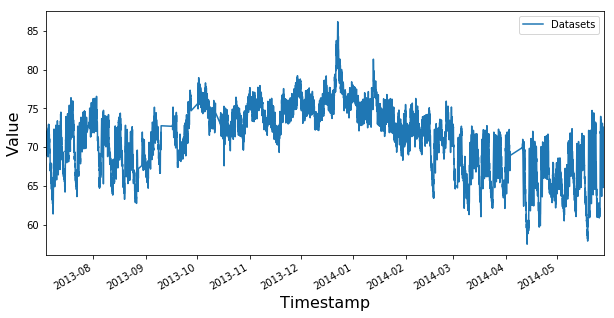

In [7]:
dataset.plot(x='timestamp', y='value', figsize=(10,5),label='Datasets')
plt.xlabel('Timestamp', fontsize=16)
plt.ylabel('Value', fontsize=16)
plt.legend()


- Our timestamp column contains some more information that we can use them to add more columns for feature engineering. In hence, I want to add more columns as hours, days and weekdays 

In [8]:
dataset['Hours'] = dataset['timestamp'].dt.hour
dataset['Days'] = dataset['timestamp'].dt.dayofweek
dataset['WeekDay'] = (dataset['Days'] < 5).astype(int)
dataset.head()

,timestamp,value,Hours,Days,WeekDay
0,2013-07-04 00:00:00,69.880835,0,3,1
1,2013-07-04 01:00:00,71.220227,1,3,1
2,2013-07-04 02:00:00,70.877805,2,3,1
3,2013-07-04 03:00:00,68.959400,3,3,1
4,2013-07-04 04:00:00,69.283551,4,3,1


## Anomaly Detection

### Interquartile Range

- Before using this approach to find the outliers,since we need just the value column, it is needed to sort the values of the temperatures . Then we can use Interquartile Range approach.

In [9]:
dataset.sort_values(by='value')
Q1,Q2, Q3= np.percentile(dataset['value'],[25,50,75])
IQR = iqr(dataset['value'])
band_low = Q1 -(1.5 * IQR) 
band_up = Q3 +(1.5 * IQR)
x=0
for i in dataset.iterrows():
    if i[1]['value'] > band_up or i[1]['value'] < band_low:
       x = x + 1            
print("Number of Anomalies is", x)
print(Q1, Q2, Q3)

dataset.describe()

Number of Anomalies is 35
68.36941051 71.85849263 74.43095786


,value,Hours,Days,WeekDay
count,7267.000000,7267.000000,7267.000000,7267.000000
mean,71.242433,11.509289,2.988579,0.721481
std,4.247509,6.927370,1.979945,0.448301
min,57.458406,0.000000,0.000000,0.000000
25%,68.369411,5.500000,1.000000,0.000000
50%,71.858493,12.000000,3.000000,1.000000
75%,74.430958,18.000000,5.000000,1.000000
max,86.223213,23.000000,6.000000,1.000000


- This is the basic math for finding those points are outlier. This is really basic and the accuracy for this approach is very low. Because of that I wanna go through other approach for raching out to higher accuracy.


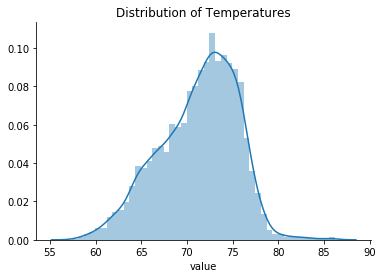

In [10]:
sns.distplot(dataset['value'])
plt.title("Distribution of Temperatures")
sns.despine()

# Isolation Forest

Isolation forest is an algorithm to detect outliers. It partitions the data using a set of trees and provides an anomaly score looking at how isolated the point is in the structure found .The isolation forest algorithm has several hyperparmaters as following:
- n_estimators: the number of trees to use
- max_samples:  The number of samples to draw while build a single tree.
- Contamination: The amount of contamination of dataset.

In [11]:

X_train = dataset.loc[:7000, ['value','Days']]
X_valid = dataset.loc[7000:, ['value','Days']]
model =  IsolationForest(n_estimators=1000, contamination = 0.05)
model.fit(X_train)
y_pred_train = model.predict(X_train)
dataset['anomaly_IF']=pd.Series(y_pred_train)
print(dataset['anomaly_IF'].value_counts())
print("Normal, Anomalies\n",dataset['anomaly_IF'].value_counts().values)


C:\Users\a335s717\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\Users\a335s717\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


 1.0    6651
-1.0     350
Name: anomaly_IF, dtype: int64
Normal, Anomalies
 [6651  350]


- Here, -1 shows the outliers values and 1 shows the normal values.

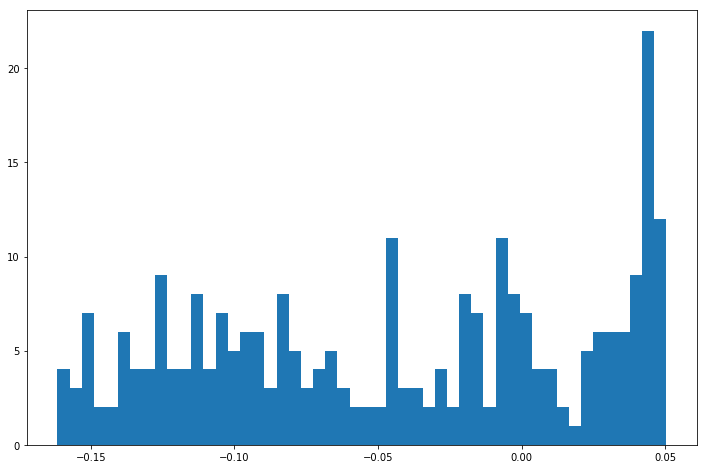

In [12]:
scores = model.decision_function(X_valid)
plt.figure(figsize=(12, 8))
plt.hist(scores, bins=50);

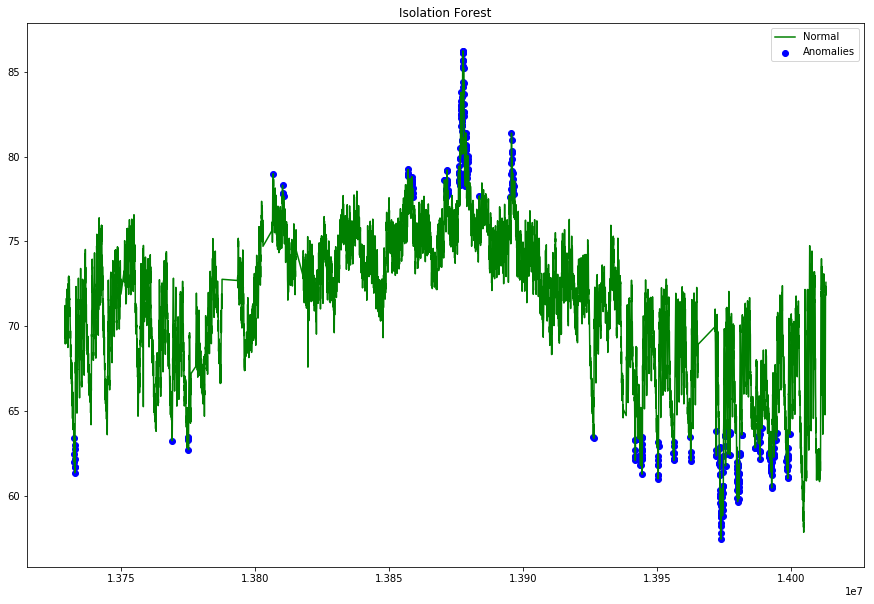

In [13]:
#Visualisation of anomaly
fig, ax = plt.subplots(figsize=(15,10))
dataset['time_epoch'] = (dataset['timestamp'].astype(np.int64)/100000000000).astype(np.int64)
anomaly_data = dataset.loc[dataset['anomaly_IF'] == -1, ['time_epoch', 'value']] #anomaly
ax.plot(dataset['time_epoch'], dataset['value'], color='green',label='Normal')
ax.scatter(anomaly_data['time_epoch'],anomaly_data['value'], color='blue',label='Anomalies')
plt.title("Isolation Forest")
plt.legend()
plt.show()

# One Class Support Vector Machine

In [14]:

X = dataset[['value', 'Days']]
min_max_scaler = preprocessing.StandardScaler()
X_scale = min_max_scaler.fit_transform(X)
model_SVM =  OneClassSVM(nu=0.95 * 0.05)
X_SVM = pd.DataFrame(X_scale)
model_SVM.fit(X_SVM)

dataset['anomaly_SVM'] = pd.Series(model_SVM.predict(X_SVM))
print(dataset['anomaly_SVM'].value_counts())


C:\Users\a335s717\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\a335s717\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


 1    6904
-1     363
Name: anomaly_SVM, dtype: int64


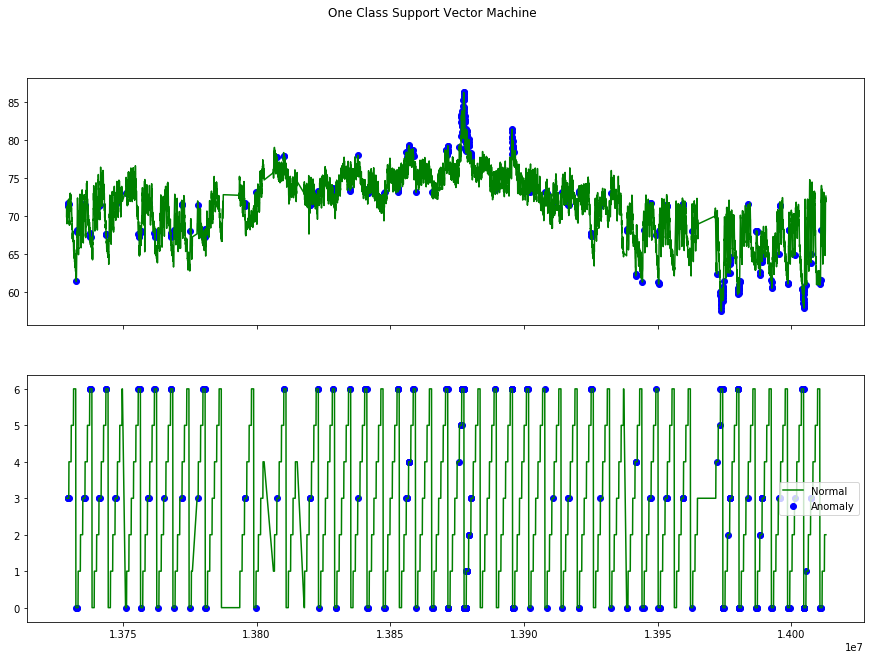

In [15]:
fig, ax = plt.subplots(2,sharex= True , figsize=(15,10))
fig.suptitle("One Class Support Vector Machine")
param = dataset.loc[dataset['anomaly_SVM'] == -1, ['time_epoch', 'value']] #anomaly
param_1 = dataset.loc[dataset['anomaly_SVM'] == -1, ['time_epoch', 'Days']] #anomaly
ax[0].plot(dataset['time_epoch'], dataset['value'], color='green',label='Normal')
ax[0].scatter(param['time_epoch'],param['value'], color='blue',label='Anomaly')
ax[1].plot(dataset['time_epoch'], dataset['Days'], color='green',label='Normal')
ax[1].scatter(param_1['time_epoch'],param_1['Days'], color='blue',label='Anomaly')
plt.legend()
plt.show()

In [16]:
dataset.head()

,timestamp,value,Hours,Days,WeekDay,anomaly_IF,time_epoch,anomaly_SVM
0,2013-07-04 00:00:00,69.880835,0,3,1,1.0,13728960,1
1,2013-07-04 01:00:00,71.220227,1,3,1,1.0,13728996,1
2,2013-07-04 02:00:00,70.877805,2,3,1,1.0,13729032,1
3,2013-07-04 03:00:00,68.959400,3,3,1,1.0,13729068,1
4,2013-07-04 04:00:00,69.283551,4,3,1,1.0,13729104,1
